[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
75.0
75.0
(7.164817810058594, -20.433265686035156, 89.85711669921875)
<class 'tuple'>
<class 'float'>
size3 (289, 405, 258)
shape3 (258, 405, 289)
(0.5, 0.5, 0.5)
(-48.23124694824219, -92.39669799804688, 46.795082092285156)
(48.26875305175781, 92.60330200195312, 163.79508209228516) (101.6648178100586, 82.06673431396484, 168.85711669921875)
box_max:  (101.6648178100586, 82.06673431396484, 168.85711669921875)
101.6648178100586
(-72.23124694824219, -138.39669799804688, 69.79508209228516)
(289, 405, 258)
(-72.23124694824219, -138.39669799804688, 69.79508209228516)
(48.26875305175781, 92.60330200195312, 163.79508209228516)
(101.6648178100586, 82.06673431396484, 168.85711669921875)
<class 'tuple'> <class 'tuple'>
0.0
<class 'numpy.ndarray'>
box41:  (241, 462, 188)
box43:  (348, 441, 198)
box43 within bounds (348, 441, 197)
origin1 with re

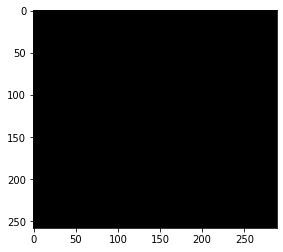

In [74]:
# retrieve size, origin, spacing
[x_size_1, y_size_1, z_size_1] = image.GetSize()
size = image.GetSize()
(x_origin_1, y_origin_1, z_origin_1) = image.GetOrigin()
origin = (x_origin_1, y_origin_1, z_origin_1)
[x_spacing_1, y_spacing_1, z_spacing_1] = image.GetSpacing()

# obtain real world coordinates of the origin
image.TransformIndexToPhysicalPoint((0,0,0))

# get details of image3. spacing is the same for all nii.gz images
size3 = image3.GetSize()
origin3 = image3.GetOrigin()
spacing3 = image3.GetSpacing()

# find overall bounding volume
box_max = max(image.TransformIndexToPhysicalPoint((size)),image3.TransformIndexToPhysicalPoint((size3)))

# why doesn't this match up to itk=snap
box_origin = min(image.TransformIndexToPhysicalPoint((int(origin[0]),int(origin[1]),int(origin[2]))),image3.TransformIndexToPhysicalPoint((int(origin3[0]),int(origin3[1]),int(origin3[2]))))
# set up new image with overall bounding volume details
size4 = image3.TransformPhysicalPointToIndex((box_max))
image4 = sitk.Image(size4, sitk.sitkFloat32)
image4.SetOrigin(box_origin)
image4.SetSpacing(spacing)

# bounding volume for image in world coordinates
box_1 = image.TransformIndexToPhysicalPoint((size))

# bounding volume for image3 in world coordinates
box_3 = image3.TransformIndexToPhysicalPoint((size3))


In [ ]:
import SimpleITK as sitk
import random
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
%matplotlib inline

ALPHA = 0.5
BLACK = float(0)

def load_image_1():
    """Loads reference image using SimpleITK"""
    image_path = "registered_7.nii.gz"
    image = sitk.ReadImage(image_path, sitk.sitkFloat32)
    arr = sitk.GetArrayFromImage(image)

def load_image_2():
    """Loads second image registered to reference image using SimpleITK"""
    image_path_2 = "registered_11to7.nii.gz"
    image2 = sitk.ReadImage(image_path_2, sitk.sitkFloat32)
    arr2 = sitk.GetArrayFromImage(image2)

def is_image_1(fused_image_coordinates):
    """Voxel coordinates that constitute image 1"""
    # if not in bounds
    if not(max_1_x - 1 > fused_image_x and max_1_y - 1 > fused_image_y and max_1_z - 1 > fused_image_z):
        return False

    # if black
    if arr[fused_image_x, fused_image_y, fused_image_z] == BLACK:
        return False
    

def is_image_2(fused_image_coordinates):
    """Voxel coordinates that constitute image 2"""

    # if not in bounds
    if not(max_2_x - 1 > fused_image_x and max_2_y - 1 > fused_image_y and max_2_z - 1 > fused_image_z):
        return False

    # if black
    if arr2[fused_image_x, fused_image_y, fused_image_z] == BLACK:
        return False
    
    return True

def is_both(fused_image_coordinates):
    """Voxel coordinates that constitute both images ie. the overlapping regions"""
    return is_image_1(fused_image_coordinates) and is_image_2(fused_image_coordinates)

def set_point(x, y, z, value):
    fused_image.SetPixel(int(x), int(y), int(z), int(value))

def output_image():
    """"""
    fused_arr = sitk.GetArrayFromImage(fused_image)
    sitk.WriteImage(fused_image, 'fused.nii.gz')
    slice_fused_image = fused_arr[:,200,:]
    plt.imshow(slice_fused_image,'gray')

# load images
load_image_1()
load_image_2()

# loop over fused image coordinates
for x in np.arange(origin_fused[0], max_fused[0] - 1):
    for y in np.arange(origin_fused[1], max_fused[1] - 1):
        for z in np.arange(origin_fused[2], max_fused[2] - 1):
            if is_both((x, y, z)):
                #alpha blending
                value = ALPHA * arr[x, y, z] + (1 - ALPHA) * arr2[x, y, z]
                set_point(x, y, z, value)
            elif is_image_1((x, y, z)):
                #get image 1 value
                value = arr[x, y, z]
                set_point(x, y, z, value)
            elif is_image_3((x, y, z)):
                #get image 2 value
                value = arr2[x, y, z]
                set_point(x, y, z, value)